In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [85]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor as RF



## Zbiór concrete

Będziemy używać podziału na zbiór treningowy i testowy (hold-out), stąd funkcja `train_test_split`

In [86]:
data = pd.read_csv("Datasets/concrete.csv")
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y)

# Granice decyzyjne

Wizualizacja granic decyzyjnych to wizualizacja uproszczonego estymatora, wytrenowanego na dwóch najważniejszych zmiennych. 

Zalety:
- określenie obszarów dobrej i złej predykcji
- określenie działania estymatora poza zakresem zmiennych

Wady:
- ujęcie tylko dwóch zmiennych

Uwaga: Funkcja pozwala na dostęp do wyników danych wejściowych i wyników estymacji poprzez atrybuty: .xx0, .xx1, .response

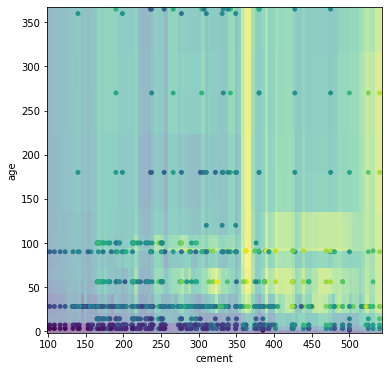

In [87]:
Xdash = X.iloc[:,[0,-1]] # pierwsza i ostatnia zmienna
regressor = RF().fit(Xdash, y)
fig,ax = plt.subplots(figsize=(6,6)) # warto to zrobić aby sterować ryciną
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=ax
)

disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)

### Porównanie granic decyzyjnych dla różnych estymatorów



In [88]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
reg_01 = DecisionTreeRegressor().fit(Xdash, y)
reg_02 = KNeighborsRegressor().fit(Xdash, y)
reg_03 = LinearRegression().fit(Xdash, y)
reg_04 = MLPRegressor().fit(Xdash, y)

Text(0.5, 1.0, 'Neural Network')

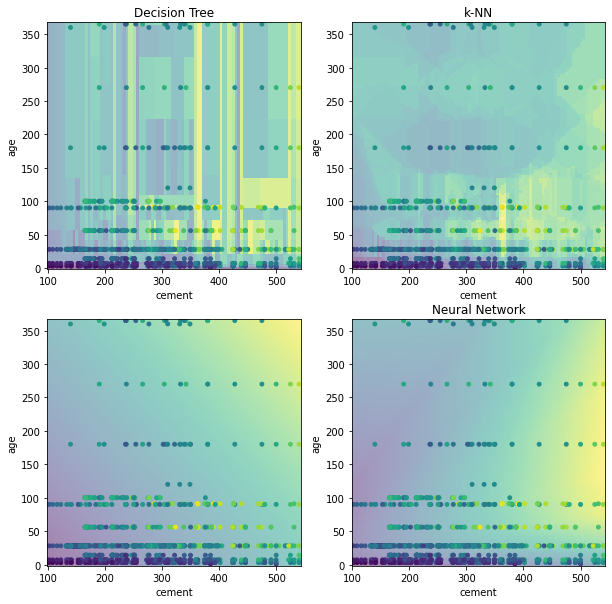

In [89]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
disp = DecisionBoundaryDisplay.from_estimator(
    reg_01, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[0][0]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][0].set_title("Decision Tree")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_02, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[0][1]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][1].set_title("Linear Regression")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_03, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[1][0]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[0][1].set_title("k-NN")

disp = DecisionBoundaryDisplay.from_estimator(
    reg_04, Xdash, response_method="predict",plot_method='pcolormesh',
    xlabel=Xdash.columns[0], ylabel=Xdash.columns[1],
    alpha=0.5,ax=axes[1][1]
)
disp.ax_.scatter(Xdash.cement,Xdash.age,c=y,s=15)
axes[1][1].set_title("Neural Network")

## Granice decyzyjne i ich wizualizacja dla transfornowanych danych

In [90]:
from sklearn.cluster import FeatureAgglomeration
from scipy.cluster.hierarchy import dendrogram,linkage,set_link_color_palette
from scipy.spatial import distance as dst

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import MDS, TSNE
scaled = scale(X)

W przypadku transformacji danych wizualizujemy zmienne, które nie są w żaden sposób interpretowalne, szczególnie w przypadku transformacji wielorakich.

In [91]:

agg = FeatureAgglomeration(n_clusters=5,distance_threshold=None,metric="euclidean",linkage='complete').fit(scaled)
trf = agg.transform(scaled)
rf = RF().fit(trf,y)
yhat = rf.predict(trf)
rf.feature_importances_

array([0.15326578, 0.25914601, 0.06797236, 0.36818091, 0.15143494])

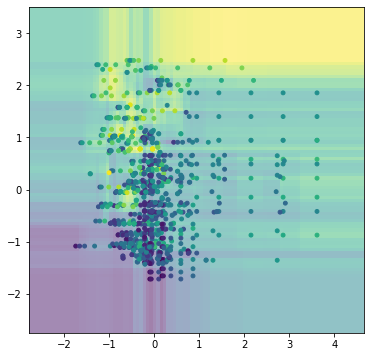

In [92]:
Xdash = trf[:,[1,3]]
regressor = RF().fit(Xdash,y)

fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

Wykres pokazuje granice decyzyjne, ale zmienne wybrane na podstawie ważności dla modelu nie są intepretowalne. Aby dodać intepretowalność, rozszerzymy wykres o część wektorową bi-plotu. W przypadku metod innych niż pca musimy obliczyć również `loadings` dla transformowanych zmiennych.

In [93]:
def crosscor(raw,transformed):
    corr = np.corrcoef(raw,transformed, rowvar=False)
    cc = corr[raw.shape[1]:,:raw.shape[1]]
    return cc

def ext_biplot(coeffx,coeffy,columns,scale=1,ax=ax):
   
    coeffx = coeffx*scale
    coeffy = coeffy*scale
    for i in range(8):
        ax.arrow(0, 0, coeffx[i], coeffy[i],color = '#990000',alpha = 1,ls=":",lw=1)
        ax.text(coeffx[i]* 1.05, coeffy[i] * 1.15, columns[i], color = '#990000', ha = 'left', va = 'center',fontsize=16)

In [94]:
loadings = crosscor(X,trf)

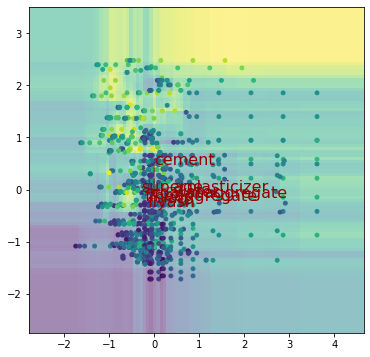

In [95]:
fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

ext_biplot(loadings[1],loadings[3],X.columns,scale=0.5,ax=ax)

W przypadku PCA, nie musimy obliczać obciążenia transformowanych zmiennych, możemy wykorzystać macierz wektorów własnych PCA (czyli components)

In [96]:
pca = PCA().fit(scaled)
loadings = pca.components_
trans = pca.transform(scaled)
regressor = RF().fit(trans,y)
print(pd.Series(regressor.feature_importances_))

0    0.042700
1    0.051124
2    0.379982
3    0.062895
4    0.144859
5    0.224186
6    0.051992
7    0.042262
dtype: float64


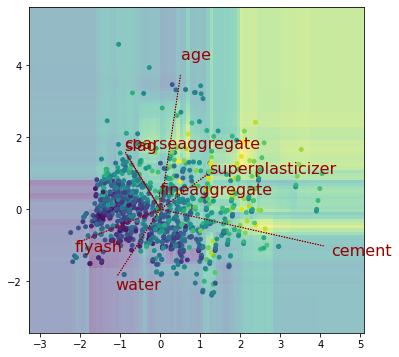

In [97]:
Xdash = trans[:,[2,5]] # component 2 i 5
regressor = RF().fit(Xdash,y)

fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

ext_biplot(loadings[2],loadings[5],X.columns,scale=5,ax=ax)

Uogólnioną formą PCA jest Analiza Czynnikowa (Factor Analysis). W tym wypadku istotne komponenty to 0 i 5

In [98]:
fa = FactorAnalysis().fit(X)
loadings = fa.components_
trans = fa.transform(X)
estimator = RF().fit(trans,y)
print(pd.Series(estimator.feature_importances_))


0    0.203138
1    0.109812
2    0.030119
3    0.055624
4    0.153579
5    0.384604
6    0.030565
7    0.032558
dtype: float64


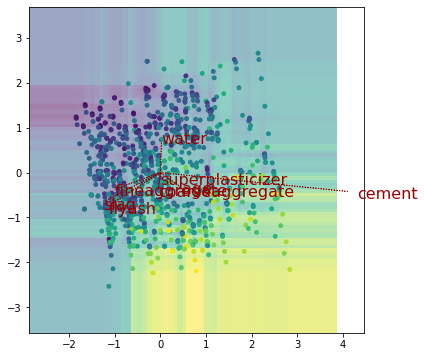

In [99]:
Xdash = trans[:,[0,5]] # component 2 i 5
regressor = RF().fit(Xdash,y)
fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

ext_biplot(loadings[0],loadings[5],X.columns,scale=0.04,ax=ax)

FA to właściwie zrotowane PCA

## Transformacje wielorakie

Porównamy granice decyzyjne dla popularnej metody redukcji wymiarowości Multidimentional Scaling, gdzie w procesie redukcji wymiarowości rzutujemy wielowymiarową przestrzeń na mniejszą ilość wymiarów, starając się zachować niepodobieństwo pomiędzy przypadkami. Jako drugą, użyjemy poznaną wcześniej metodę TSNE. W obu przypadkach redukujemy do dwóch wymiarów a więc nie musimy poszukiwać zmiennych o najwyższym potencjale wyjaśniającym. Niestety ponownie do obliczenia loadings musimy wykorzystać korelację między zmiennymi

In [100]:
mds = MDS(n_components=2,normalized_stress='auto')
trans = mds.fit_transform(X)
loadings = crosscor(X,trans)

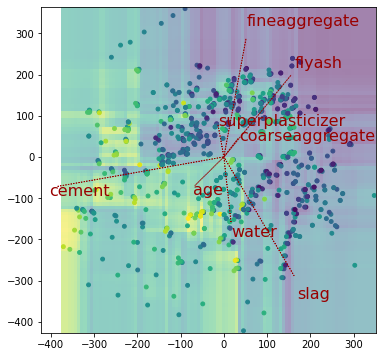

In [101]:
Xdash = trans 
regressor = RF().fit(Xdash,y)
fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

ext_biplot(loadings[0],loadings[1],X.columns,scale=400,ax=ax)

In [102]:
SNE = TSNE(n_components=2)
trans = SNE.fit_transform(X)
loadings = crosscor(X,trans)

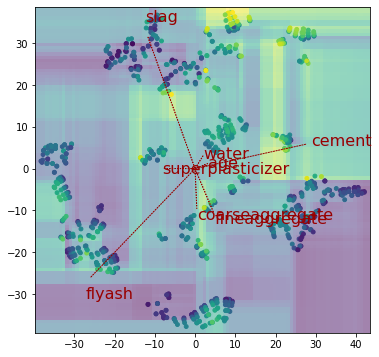

In [103]:
Xdash = trans 
regressor = RF().fit(Xdash,y)
fig, ax = plt.subplots(figsize=(6,6))
disp = DecisionBoundaryDisplay.from_estimator(
    regressor, Xdash, response_method="predict",plot_method='pcolormesh',
    alpha=0.5,ax=ax
)

disp.ax_.scatter(*Xdash.T,c=y,s=15)

ext_biplot(loadings[0],loadings[1],X.columns,scale=40,ax=ax)